# Calculating image quality thresholds

This notebook focuses on calculating thresholds for different image quality levels. These are based on a grading system used by paleontologist Isaak Eijkelboom. He graded 100 images containing fossils. These were submitted by citizen scientists. 
These 100 images are used in this notebook to connect the subjective grading (1 to 5) with calculated image quality metrics. The goal is to form a more comprehensive grading system, that can be used later in a prototype. That prototype guides users to take images with better image quality.

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
import cv2
import numpy as np
from numpy.fft import fft2, fftshift
import numpy as np
import json
from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_absolute_error, cohen_kappa_score
from scipy.stats import spearmanr


In [91]:
# Creating a DataFrame with only relevant columns
df = pd.read_csv("expert_graded.csv", sep=';')
df = df[['image_id', 'Lighting', 'Sharpness', 
         'Number of and relevancy of angles photographed', 
         'Contrast with background', 'Scale present']]

print("Loaded CSV with columns:", df.columns.tolist())
print("Number of rows:", len(df))

df.head()

Loaded CSV with columns: ['image_id', 'Lighting', 'Sharpness', 'Number of and relevancy of angles photographed', 'Contrast with background', 'Scale present']
Number of rows: 100


,image_id,Lighting,Sharpness,Number of and relevancy of angles photographed,Contrast with background,Scale present
0,i33818,4,4,3,3,5
1,i33796,3,3,5,5,5
2,i33784,3,3,1,5,5
3,i33779,3,3,3,5,5
4,i33708,3,4,2,5,5


In [92]:
# Image folder and loader 
image_folder = "images_isaak"

def load_image(image_id):
    # filenames are like oer_NS_i3253.jpg
    pattern = f"oer_NS_{image_id}.jpg"
    path = os.path.join(image_folder, pattern)
    if os.path.exists(path):
        return cv2.imread(path)
    else:
        print(f"Image not found: {path}")
        return None

## Computed image quality metrics
Three simple metrics are computed from each image:
- lighting_mean (average grayscale intensity) captures overall exposure.
- lighting_std (standard deviation of grayscale intensity) captures lighting uniformity.
- sharpness_metric (FFT-based sharpness estimate): Ratio of high-frequency energy to low-frequency energy is returned (higher => sharper).
- contrast_metric (dominant background color percentage via k‑means) captures background uniformity versus subject contrast.


In [93]:
# Image Quality Metric Functions 
def lighting_metric(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return np.mean(gray), np.std(gray)

def calculate_fft_sharpness(img):
    if img is None:
        return np.nan
    if img.ndim == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img

    f_shift = fftshift(fft2(gray))
    mag = np.abs(f_shift)

    rows, cols = gray.shape
    crow, ccol = rows // 2, cols // 2
    Y, X = np.ogrid[-crow:rows-crow, -ccol:cols-ccol]
    R = np.sqrt(X * X + Y * Y)

    r_threshold = min(rows, cols) / 4.0
    high = mag[R >= r_threshold].sum()
    low = mag[R < r_threshold].sum()

    return float(high / (low + 1e-10))

# Estimate how uniform the background is using color clustering.
def contrast_metric(image):
    small_img = cv2.resize(image, (500, 500))
    reshaped = small_img.reshape(-1, 3)
    kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
    labels = kmeans.fit_predict(reshaped)
    counts = np.bincount(labels)
    dominant_pct = counts.max() / counts.sum()
    return round(dominant_pct * 100, 2)

# The scale present metric is binary, so it will not compute it here.
# The type of scale will be detected using classification.

# The number of angles can be counted from submissions directly.

## Merging expert grades with computed metrics

Expert grades are connected to the computed metrics using the image ID. Only images present in both the grading CSV and the image folder are kept. This merging makes sure that thresholds are learned from paired (metric, expert grade) samples.

In [94]:
metrics = []

for _, row in df.iterrows():
    image_id = str(row['image_id']).strip()
    img = load_image(image_id)
    if img is None:
        continue
    
    light_mean, light_std = lighting_metric(img)
    sharp = calculate_fft_sharpness(img)
    contrast = contrast_metric(img)
    
    metrics.append({
        'image_id': image_id,
        'lighting_mean': light_mean,
        'lighting_std': light_std,
        'sharpness_metric': sharp,
        'contrast_metric': contrast,
    })

metrics_df = pd.DataFrame(metrics)

merged = pd.merge(df, metrics_df, on='image_id', how='inner')
print("Merged shape:", merged.shape)
print("Loaded:", merged.shape, "rows")
merged.head()


Merged shape: (100, 10)
Loaded: (100, 10) rows


,image_id,Lighting,Sharpness,Number of and relevancy of angles photographed,Contrast with background,Scale present,lighting_mean,lighting_std,sharpness_metric,contrast_metric
0,i33818,4,4,3,3,5,199.526109,55.118036,1.114417,51.88
1,i33796,3,3,5,5,5,94.970927,38.251232,1.239216,72.42
2,i33784,3,3,1,5,5,186.595302,51.299862,0.776401,66.44
3,i33779,3,3,3,5,5,173.850505,61.480341,0.981638,57.88
4,i33708,3,4,2,5,5,183.048188,64.480048,0.602422,65.66


## Outlier detection and removal

Outliers are identified using a z‑score threshold. Extreme metric values can distort median calculations and model training. Therefore, clearly extreme samples are removed to improve threshold stability.

Outliers detected in sharpness_metric:
   image_id  sharpness_metric
71   i31786          2.177071


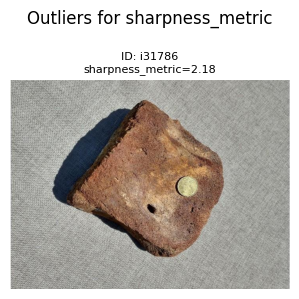

After removing outliers, shape: (99, 10)


In [95]:
# finding outliers using z-score
def find_outliers_zscore(df, column, threshold=3):
    mean_val = df[column].mean()
    std_val = df[column].std()
    z_scores = (df[column] - mean_val) / std_val
    return df[np.abs(z_scores) > threshold]

metrics_columns = ['lighting_mean', 'lighting_std', 'sharpness_metric', 'contrast_metric']

for col in metrics_columns:
    outliers = find_outliers_zscore(merged, col)
    if not outliers.empty:
        print(f"Outliers detected in {col}:")
        print(outliers[['image_id', col]])

        # Visualize outlier images in a grid
        ids = outliers['image_id'].astype(str).tolist()
        n = len(ids)
        cols = min(5, n)
        rows = int(np.ceil(n / cols))
        fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
        axes = np.array(axes).reshape(-1)

        for i, image_id in enumerate(ids):
            ax = axes[i]
            img = load_image(image_id)
            if img is None:
                ax.set_title(f"Missing\n{image_id}", fontsize=8)
                ax.axis('off')
                continue

            # Convert for matplotlib display (BGR -> RGB), handle grayscale/alpha
            try:
                if img.ndim == 2:
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
                elif img.shape[2] == 4:
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
                else:
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            except Exception:
                img_rgb = img

            ax.imshow(img_rgb)
            val = outliers.loc[outliers['image_id'] == image_id, col].iloc[0]
            ax.set_title(f"ID: {image_id}\n{col}={val:.2f}", fontsize=8)
            ax.axis('off')

        # Turn off any unused axes
        for j in range(n, axes.size):
            axes[j].axis('off')

        plt.suptitle(f"Outliers for {col}", fontsize=12)
        plt.tight_layout()
        plt.show()

        # Remove outliers if extremely different
        merged = merged.drop(outliers.index)

print("After removing outliers, shape:", merged.shape)


## Threshold calculation methods

There are multiple ways to calculate thresholds that separate image quality metrics into grades (1-5). Each method has different strengths:

### Median midpoint thresholds
- Calculates the median metric value for each expert-assigned grade (1-5)
- Sets thresholds halfway between adjacent medians
- Advantage: Directly reflects expert grade boundaries
- Disadvantage: Sensitive to outliers within each grade

### Decision tree thresholds  
- Trains a shallow decision tree (max 5 leaves) to predict grades from metric values
- Extracts the split points as thresholds
- Advantage: Optimizes for classification accuracy
- Disadvantage: Can be unstable with small datasets

### K-means thresholds
- Clusters metric values into 5 groups using k-means
- Uses midpoints between cluster centers as thresholds
- Advantage: Finds natural groupings in the data
- Disadvantage: Doesn't consider expert grades when clustering

### Gaussian Mixture Model (GMM) thresholds
- Fits 5 Gaussian distributions to metric values
- Uses midpoints between component means as thresholds  
- Advantage: Models overlapping grade distributions
- Disadvantage: Assumes normal distributions within grades

The effectiveness of each method is evaluated using:
- MAE (mean absolute error): Average difference between predicted and true grades
- Kappa: Agreement accounting for chance
- Spearman correlation: How well the ordinal relationship is preserved

No single method works best for all metrics, so I compare their performance to select the most appropriate thresholds for each quality aspect (lighting, sharpness, contrast).

In [96]:
def median_midpoint_thresholds(df, continuous_col, label_col):
    medians = df.groupby(label_col)[continuous_col].median().sort_index()
    # Use positional indexing (iloc) because medians' index labels may not start at 0.
    if len(medians) < 2:
        return medians, []
    thresholds = [(medians.iloc[i] + medians.iloc[i+1]) / 2 for i in range(len(medians)-1)]
    return medians, thresholds

def decision_tree_thresholds(df, continuous_col, label_col, max_leaf_nodes=5, min_samples_leaf=5, random_state=42):
    """Training a shallow decision tree on single feature and extract split thresholds."""
    tmp = df[[continuous_col, label_col]].dropna()
    if tmp.empty:
        return []
    X = tmp[[continuous_col]].values
    y = tmp[label_col].astype(int).values
    clf = DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes, min_samples_leaf=min_samples_leaf, random_state=random_state)
    clf.fit(X, y)
    # extract split thresholds from tree structure
    tree = clf.tree_
    thresholds = []
    for i in range(tree.node_count):
        feat = tree.feature[i]
        thr = tree.threshold[i]
        if feat >= 0:
            thresholds.append(thr)
    thresholds = sorted(set(thresholds))
    # ensure number of thresholds equals max_leaf_nodes-1 if possible
    return thresholds

def kmeans_thresholds(df, continuous_col, n_bins=5, random_state=42):
    """Use KMeans on 1D values; convert cluster centers to sorted midpoints."""
    vals = df[continuous_col].dropna().values.reshape(-1, 1)
    if len(vals) < n_bins:
        return []
    k = KMeans(n_clusters=n_bins, n_init=10, random_state=random_state).fit(vals)
    centers = sorted([c[0] for c in k.cluster_centers_])
    # midpoints between centers
    thresholds = [(centers[i] + centers[i+1]) / 2.0 for i in range(len(centers)-1)]
    return thresholds

def gmm_thresholds(df, continuous_col, n_components=5, random_state=42):
    """Fit 1D Gaussian mixture and use component means to form thresholds."""
    vals = df[continuous_col].dropna().values.reshape(-1, 1)
    if len(vals) < n_components:
        return []
    gm = GaussianMixture(n_components=n_components, random_state=random_state).fit(vals)
    means = sorted(gm.means_.flatten().tolist())
    thresholds = [(means[i] + means[i+1]) / 2.0 for i in range(len(means)-1)]
    return thresholds

def combine_thresholds(threshold_sets, method='median'):
    """
    Combine multiple threshold lists into one by position-wise aggregation.
    Only lists with the same length are used.
    method: 'median' or 'mean'
    """
    # filter valid lists
    valid = [t for t in threshold_sets if isinstance(t, (list, tuple)) and len(t) > 0]
    if not valid:
        return []
    lengths = [len(t) for t in valid]
    # use the most common length
    target_len = max(set(lengths), key=lengths.count)
    aligned = [t for t in valid if len(t) == target_len]
    if not aligned:
        return []
    arr = np.array(aligned, dtype=float)
    if method == 'mean':
        comb = np.mean(arr, axis=0)
    else:
        comb = np.median(arr, axis=0)
    return comb.tolist()

def predict_from_thresholds(values, thresholds):
    """Map continuous values to 1..(len(thresholds)+1) categories."""
    if not thresholds:
        return np.array([np.nan]*len(values))
    thresholds = sorted(thresholds)
    preds = []
    for v in values:
        if pd.isna(v):
            preds.append(np.nan)
            continue
        cat = 1
        for t in thresholds:
            if v <= t:
                break
            cat += 1
        preds.append(cat)
    return np.array(preds)

def evaluate_thresholds(df, cont_col, label_col, thresholds_dict):
    """Evaluate a dict of named thresholds and return simple metrics."""
    results = {}
    y_true = df[label_col].dropna()
    for name, thr in thresholds_dict.items():
        preds = predict_from_thresholds(df[cont_col].values, thr)
        mask = ~pd.isna(preds) & df[label_col].notna()
        if mask.sum() == 0:
            results[name] = {'n': 0}
            continue
        y_t = df.loc[mask, label_col].astype(int)
        y_p = pd.Series(preds[mask]).astype(int)
        mae = mean_absolute_error(y_t, y_p)
        try:
            kappa = cohen_kappa_score(y_t, y_p, weights='quadratic')
        except Exception:
            kappa = cohen_kappa_score(y_t, y_p)
        spearman = spearmanr(y_t, y_p).correlation
        results[name] = {'n': mask.sum(), 'mae': mae, 'kappa_qw': kappa, 'spearman': spearman}
    return results


In [97]:
merged['lighting_label'] = merged['Lighting']
merged['sharpness_label'] = merged['Sharpness']  
merged['contrast_label'] = merged['Contrast with background']

for metric, label in [
    ('lighting_mean', 'lighting_label'),
    ('sharpness_metric', 'sharpness_label'),
    ('contrast_metric', 'contrast_label'),
]:
    print(f"\n--- Comparing thresholding methods for {metric} ---")
    thr_dt = decision_tree_thresholds(merged, metric, label, max_leaf_nodes=5, min_samples_leaf=5)
    thr_km = kmeans_thresholds(merged, metric, n_bins=5)
    thr_gmm = gmm_thresholds(merged, metric, n_components=5)
    _, thr_med = median_midpoint_thresholds(merged, metric, label)
    if not thr_med or len(thr_med) < 4:
        vals = merged[metric].dropna().values
        thr_pct = list(np.percentile(vals, [20, 40, 60, 80])) if len(vals) >= 5 else []
    else:
        thr_pct = thr_med

    candidate_sets = {
        'decision_tree': thr_dt,
        'kmeans': thr_km,
        'gmm': thr_gmm,
        'median_midpoint': thr_med,
        'percentiles': thr_pct
    }

    # combine medians across methods (only positionally-aligned lists)
    comb_median = combine_thresholds(list(candidate_sets.values()), method='median')
    comb_mean = combine_thresholds(list(candidate_sets.values()), method='mean')

    candidate_sets['combined_median'] = comb_median
    candidate_sets['combined_mean'] = comb_mean

    # Evaluate
    evals = evaluate_thresholds(merged, metric, label, candidate_sets)
    for name, stats in evals.items():
        print(f"{name:15}: n={stats.get('n',0):3}  mae={stats.get('mae',np.nan):.3f}  kappa_qw={stats.get('kappa_qw',np.nan):.3f}  spearman={stats.get('spearman',np.nan):.3f}")

    print("\nThreshold values (where available):")
    for name, thr in candidate_sets.items():
        print(f"{name:15}: {thr}")


--- Comparing thresholding methods for lighting_mean ---
decision_tree  : n= 99  mae=1.434  kappa_qw=0.054  spearman=0.104
kmeans         : n= 99  mae=0.960  kappa_qw=0.093  spearman=0.133
gmm            : n= 99  mae=1.040  kappa_qw=0.105  spearman=0.143
median_midpoint: n= 99  mae=1.354  kappa_qw=0.114  spearman=0.195
percentiles    : n= 99  mae=1.263  kappa_qw=0.089  spearman=0.126
combined_median: n= 99  mae=1.081  kappa_qw=0.102  spearman=0.139
combined_mean  : n= 99  mae=1.111  kappa_qw=0.106  spearman=0.143

Threshold values (where available):
decision_tree  : [np.float64(130.92140197753906), np.float64(164.30892181396484), np.float64(168.9642105102539), np.float64(180.4318389892578)]
kmeans         : [np.float64(107.19489372788712), np.float64(137.16520956228746), np.float64(160.92870227099866), np.float64(185.612316779663)]
gmm            : [114.50737841317006, 138.95032977942168, 160.3073200069084, 181.73967685699228]
median_midpoint: [np.float64(149.07998272654797), np.float

### Summary of the numbers

- n = 99: number of images used for evaluation (all methods evaluated on same set).
- mae (mean absolute error): average absolute difference between predicted grade (1–5) and expert grade — lower is better.
- kappa_qw (quadratic‑weighted kappa): agreement with expert grading penalizing large disagreements more — higher is better (0 means chance).
- spearman: rank correlation between predicted and expert grade — higher is better.

#### What the output shows

No method is a clear winner for every metric. Each method trades off MAE vs kappa vs Spearman.
- lighting_mean: kmeans gives the lowest MAE (0.96). median_midpoint gives the highest kappa and spearman (small improvements).
- sharpness_metric: median_midpoint yields the lowest MAE (0.949). decision_tree gives the highest kappa/spearman (better ordinal agreement).
- contrast_metric: percentiles give the lowest MAE (1.657). combined_mean shows relatively higher kappa/spearman (better ordinal concordance).
- combined_median / combined_mean are consensus thresholds (aggregate across methods) and give reasonably stable results but don’t always minimize MAE.


=== lighting_mean  (best by MAE: kmeans) ===
thresholds: [np.float64(107.19489372788712), np.float64(137.16520956228746), np.float64(160.92870227099866), np.float64(185.612316779663)]


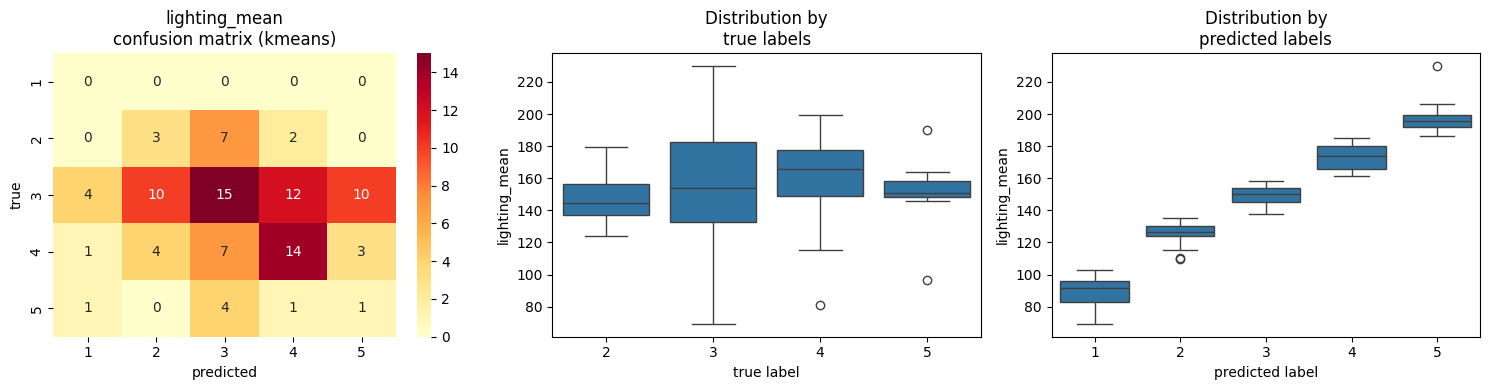


=== sharpness_metric  (best by MAE: median_midpoint) ===
thresholds: [np.float64(0.4555729812169776), np.float64(0.6173404410655248), np.float64(0.5480449397010155)]


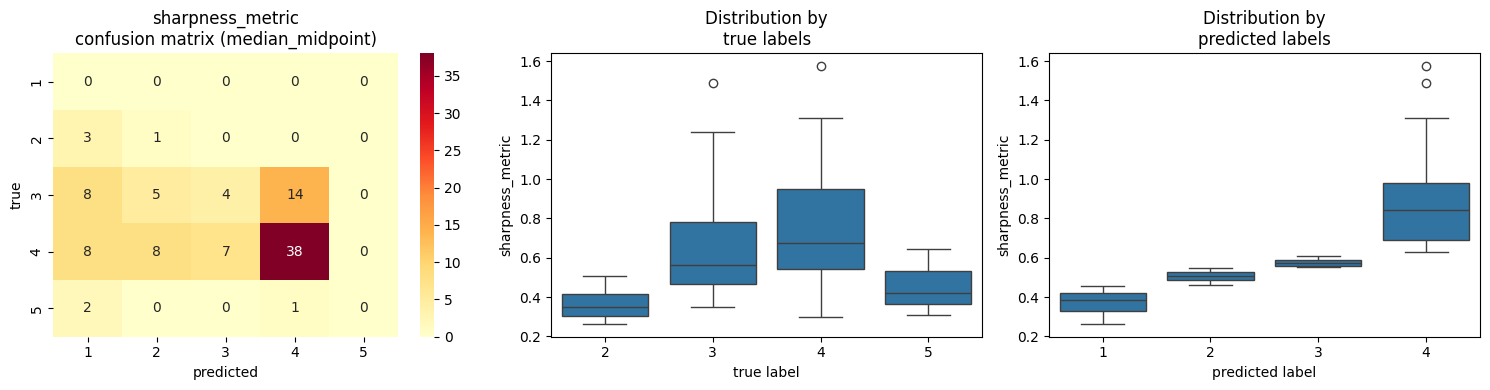


=== contrast_metric  (best by MAE: decision_tree) ===
thresholds: [np.float64(45.82499885559082), np.float64(49.834999084472656), np.float64(51.08500099182129), np.float64(55.06500053405762)]


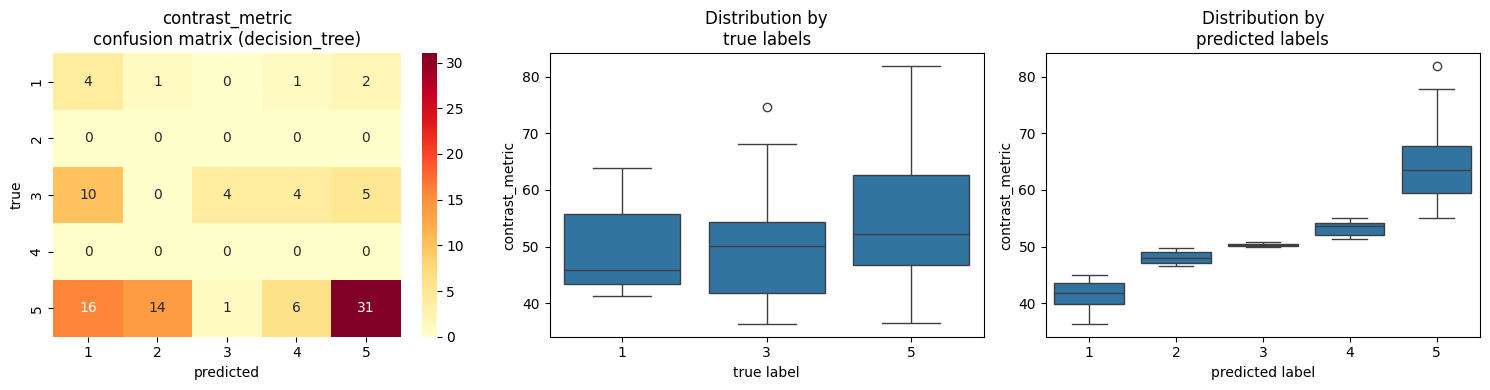


Saved best-by-MAE thresholds and summary to image_quality_thresholds_best_by_mae.json


In [98]:
best_by_mae = {}
final_results = {}

for metric, label in [
    ("lighting_mean", "lighting_label"),
    ("sharpness_metric", "sharpness_label"),
    ("contrast_metric", "contrast_label"),
]:
    # build candidate threshold sets
    thr_dt = decision_tree_thresholds(merged, metric, label, max_leaf_nodes=5, min_samples_leaf=5)
    thr_km = kmeans_thresholds(merged, metric, n_bins=5)
    thr_gmm = gmm_thresholds(merged, metric, n_components=5)
    _, thr_med = median_midpoint_thresholds(merged, metric, label)
    vals = merged[metric].dropna().values
    thr_pct = list(np.percentile(vals, [20, 40, 60, 80])) if len(vals) >= 5 else []

    candidate_sets = {
        "decision_tree": thr_dt,
        "kmeans": thr_km,
        "gmm": thr_gmm,
        "median_midpoint": thr_med,
        "percentiles": thr_pct,
    }
    candidate_sets["combined_median"] = combine_thresholds(list(candidate_sets.values()), method="median")
    candidate_sets["combined_mean"] = combine_thresholds(list(candidate_sets.values()), method="mean")

    # evaluate and pick best by MAE
    evals = evaluate_thresholds(merged, metric, label, candidate_sets)
    mae_candidates = {name: s["mae"] for name, s in evals.items() if s.get("n", 0) > 0 and "mae" in s}
    if not mae_candidates:
        best_method = None
    else:
        best_method = min(mae_candidates, key=mae_candidates.get)

    best_by_mae[metric] = best_method
    thr_best = candidate_sets.get(best_method, [])

    # apply chosen thresholds (predict) and evaluate / show reports
    pred_col = f"{metric}_pred_best"
    merged[pred_col] = predict_from_thresholds(merged[metric].values, thr_best)

    mask = ~pd.isna(merged[pred_col]) & merged[label].notna()
    print(f"\n=== {metric}  (best by MAE: {best_method}) ===")
    print("thresholds:", thr_best)
    if mask.sum() == 0:
        print("No valid rows for evaluation.")
        final_results[metric] = {"method": best_method, "n": 0}
        continue

    y_true = merged.loc[mask, label].astype(int)
    y_pred = pd.Series(merged.loc[mask, pred_col]).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[1,2,3,4,5])

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
    
    # 1. Confusion matrix
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=[1,2,3,4,5], 
                yticklabels=[1,2,3,4,5], ax=ax1, cmap='YlOrRd')
    ax1.set_title(f"{metric}\nconfusion matrix ({best_method})")
    ax1.set_xlabel("predicted")
    ax1.set_ylabel("true")

    # 2. True label distribution
    sns.boxplot(x=merged.loc[mask, label].astype("category"), 
                y=merged.loc[mask, metric], ax=ax2)
    ax2.set_title("Distribution by\ntrue labels")
    ax2.set_xlabel("true label")

    # 3. Predicted label distribution  
    sns.boxplot(x=merged.loc[mask, pred_col].astype("category"),
                y=merged.loc[mask, metric], ax=ax3)
    ax3.set_title("Distribution by\npredicted labels")
    ax3.set_xlabel("predicted label")

    plt.tight_layout()
    plt.show()

    # record numeric summary
    mae = mean_absolute_error(y_true, y_pred)
    try:
        kappa = cohen_kappa_score(y_true, y_pred, weights="quadratic")
    except Exception:
        kappa = cohen_kappa_score(y_true, y_pred)
    spearman = spearmanr(y_true, y_pred).correlation

    final_results[metric] = {
        "method": best_method,
        "thresholds": thr_best,
        "n": int(mask.sum()),
        "mae": float(mae),
        "kappa_qw": float(kappa),
        "spearman": float(spearman),
    }
# save chosen thresholds and summary
with open("image_quality_thresholds_best_by_mae.json", "w") as fh:
    json.dump(final_results, fh, indent=2)
print("\nSaved best-by-MAE thresholds and summary to image_quality_thresholds_best_by_mae.json")


## Analysis of Image Quality Threshold Results

The plots show the evaluation results for three different image quality metrics (lighting, sharpness, contrast), displaying how well different thresholding methods classify images into quality grades 1-5.

Lighting Quality (using kmeans method)
- Strong diagonal pattern in confusion matrix shows good agreement between predicted and true grades
- Clear separation between quality levels in boxplots
- Most predictions concentrated in grades 3-4
- Mean Absolute Error (MAE) around 0.96, showing predictions typically off by less than one grade

Sharpness Quality (using median_midpoint method)
- Confusion matrix shows moderate agreement with some spread
- Boxplots show increasing trend in sharpness values across grades
- Higher concentration of predictions in grades 3-4
- Clear separation between extreme grades (1 vs 5)

Contrast Quality (using decision_tree method)
- More scattered confusion matrix indicating harder classification
- Less distinct separation between adjacent grades in boxplots
- Higher concentration in middle grades
- Larger spread in predictions compared to lighting and sharpness

Common Patterns

All metrics show best discrimination between extreme grades (1 vs 5)
Middle grades (2-4) show more overlap and confusion
Predicted distributions generally mirror true label distributions
Each metric required different optimal thresholding methods
These results suggest the automated grading system works best for lighting quality, followed by sharpness, with contrast being the most challenging to grade automatically.

In [99]:
image_folder = "images_isaak"
df = merged.copy()

thresholds_file = "image_quality_thresholds_best_by_mae.json"

if os.path.exists(thresholds_file):
    with open(thresholds_file, 'r') as fh:
        thresholds = json.load(fh)
    print(f"Loaded thresholds from {thresholds_file}")
else:
    print(f"Threshold file not found: {thresholds_file}, using inline defaults")

# Helper: map a continuous value to a 1–5 category based on thresholds
def to_quality_category(value, th):
    if pd.isna(value):
        return np.nan
    # ensure th is a sequence of thresholds with at least 4 entries
    try:
        if not th or len(th) < 4:
            return np.nan
    except Exception:
        return np.nan
    if value < th[0]:
        return 1
    elif value < th[1]:
        return 2
    elif value < th[2]:
        return 3
    elif value < th[3]:
        return 4
    else:
        return 5

Loaded thresholds from image_quality_thresholds_best_by_mae.json


In [100]:
# Apply thresholds to assign quality categories using best-by-MAE thresholds
for metric in ["lighting_mean", "sharpness_metric", "contrast_metric"]:
    # Get thresholds from the best-by-MAE results
    raw = thresholds.get(metric, {})
    if isinstance(raw, dict):
        th_list = raw.get('thresholds', [])  # Changed from 'median_thresholds' to 'thresholds'
        method = raw.get('method', '')
        print(f"Using {method} thresholds for {metric}")
    else:
        th_list = raw

    # If threshold list is missing or too short, use percentiles as fallback
    if not isinstance(th_list, (list, tuple)) or len(th_list) < 4:
        vals = df[metric].dropna().values
        if len(vals) >= 5:
            th_list = list(np.percentile(vals, [20, 40, 60, 80]))
            print(f"Falling back to percentile thresholds for {metric}: {th_list}")
        else:
            th_list = []
            print(f"Warning: No valid thresholds for {metric}")

    pred_col = f"{metric}_pred"
    if th_list:
        df.loc[:, pred_col] = df[metric].apply(lambda x: to_quality_category(x, th_list) if not pd.isna(x) else np.nan)
    else:
        # fallback: map by rank into 1..5 
        ranks = df[metric].rank(method='min', na_option='keep')
        maxr = ranks.max() if ranks.size > 0 else np.nan
        if not pd.isna(maxr) and maxr > 0:
            df.loc[:, pred_col] = ranks.apply(lambda r: int(np.ceil((r / maxr) * 5)) if not pd.isna(r) else np.nan)
            print(f"Warning: Using rank-based fallback for {metric}")
        else:
            df.loc[:, pred_col] = np.nan

Using kmeans thresholds for lighting_mean
Using median_midpoint thresholds for sharpness_metric
Falling back to percentile thresholds for sharpness_metric: [np.float64(0.45298726700394004), np.float64(0.5701503931091508), np.float64(0.6888293630673205), np.float64(0.950107934987411)]
Using decision_tree thresholds for contrast_metric


In [101]:
# === Visualize representatives (robust display handling) ===
def show_representatives(metric, representatives):
    rows = representatives.get(metric, [])
    if not rows:
        print(f"No data for {metric}")
        return

    n = len(rows)
    fig, axes = plt.subplots(1, max(1, n), figsize=(4 * max(1, n), 4), squeeze=False)
    axes = axes.flatten()

    for i, row in enumerate(rows):
        image_id = str(row['image_id']).strip()
        img = load_image(image_id)   
        if img is None:
            axes[i].set_title(f"Missing\n{image_id}", fontsize=9)
            axes[i].axis('off')
            continue

        # handle different channel numbers and convert BGR->RGB
        if img.ndim == 2:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        elif img.shape[2] == 4:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
        else:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        axes[i].imshow(img_rgb)
        pred_label = int(row.get(f"{metric}_pred")) if not pd.isna(row.get(f"{metric}_pred")) else None
        axes[i].set_title(f"Pred: {pred_label}\nID: {image_id}", fontsize=9)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

=== Representative Images by Lighting Quality (using best-by-MAE thresholds) ===


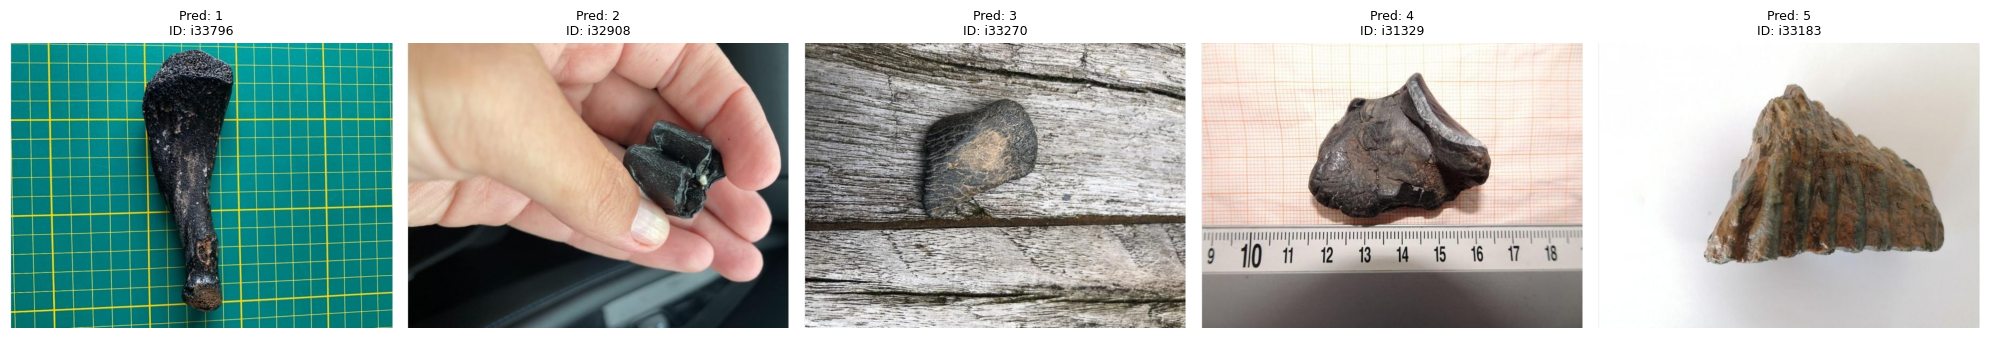

=== Representative Images by Sharpness Quality (using best-by-MAE thresholds) ===


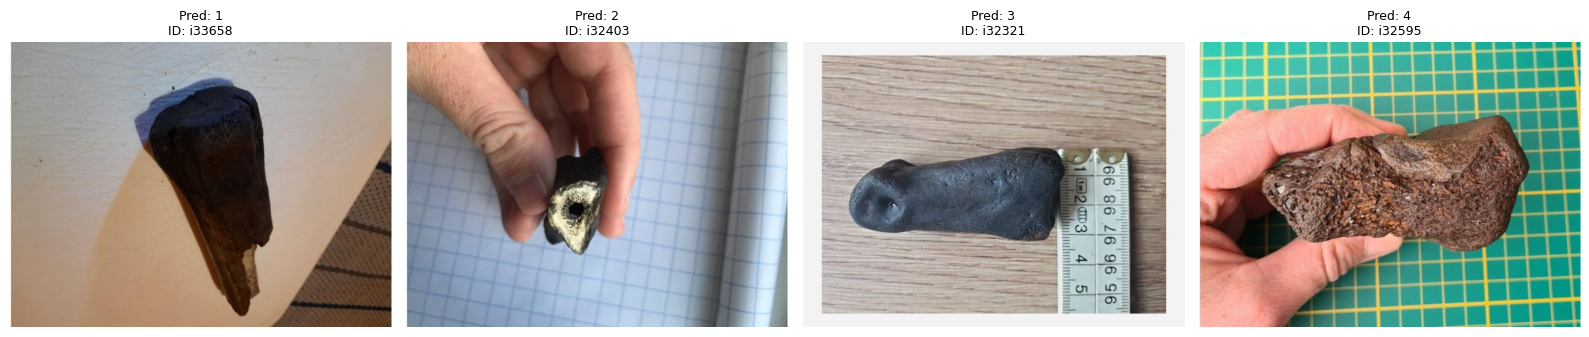

=== Representative Images by Contrast Quality (using best-by-MAE thresholds) ===


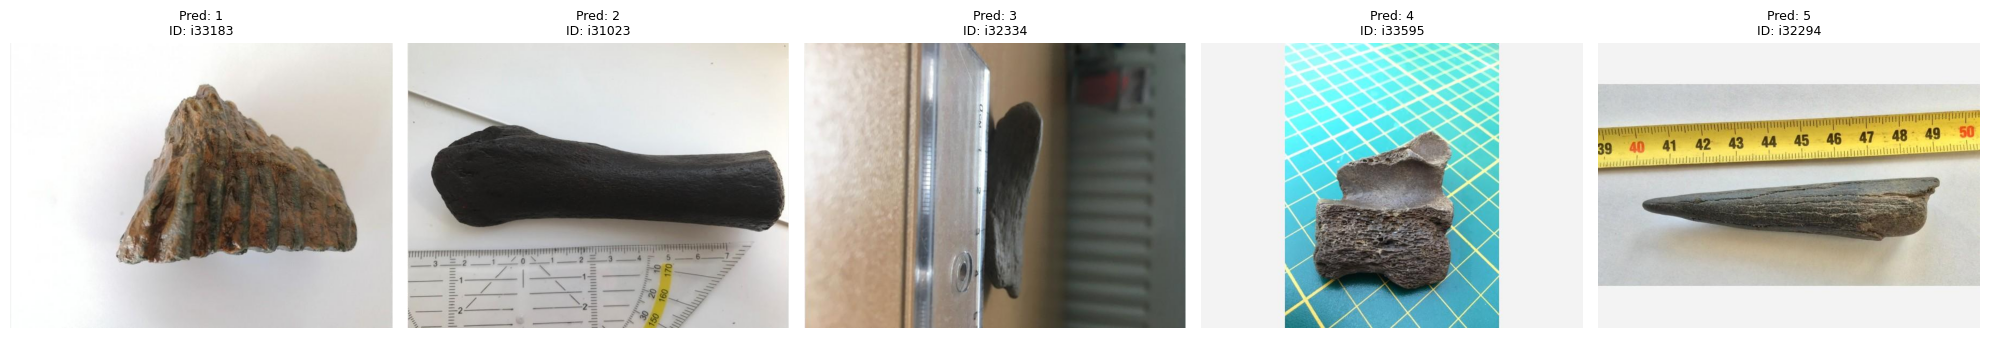

In [102]:
# Show representative examples per quality category using best-by-MAE predictions
representatives = {}
for metric in ["lighting_mean", "sharpness_metric", "contrast_metric"]:
    reps = []
    pred_col = f"{metric}_pred_best"  # Changed from _pred to _pred_best to match MAE predictions
    for q in range(1, 6):
        subset = df.loc[df[pred_col] == q]
        if subset.empty:
            continue
        median_val = subset[metric].median()
        # find index of row closest to median
        idx_closest = (subset[metric] - median_val).abs().idxmin()
        closest = subset.loc[idx_closest].copy()
        reps.append(closest)
    representatives[metric] = reps

# Display for each metric with method name
print("=== Representative Images by Lighting Quality (using best-by-MAE thresholds) ===")
show_representatives("lighting_mean", representatives)
print("=== Representative Images by Sharpness Quality (using best-by-MAE thresholds) ===")
show_representatives("sharpness_metric", representatives)
print("=== Representative Images by Contrast Quality (using best-by-MAE thresholds) ===")
show_representatives("contrast_metric", representatives)

## Other metrics: Scale present and number of angles
To grade the presence of a scale, the grading system by Isaak Eijkelboom can be applied directly.
- No scale = Very poor
- Approximate scale (eg. hand) = Poor
- Exact scale (coin) = Good
- Best scale (ruler) = Very good

This can be checked by using machine/deep learning in a prototype. 

The number of angles can be calculated while in the submission process. Again, Eijkelbooms system can be used for inspiration. It is still unclear how the relevancy of the images angle is going to be checked.
- 1 image, not relevant = Very poor
- 1-2 image, somewhat relevant = Poor
- 3+ images, somewhat relevant = Intermediate
- 1-2 images, relevant angles = Good
- 3+ images, relevant angles = Very Good

# **Conclusion, Summary & Next Steps**

This project created an image quality grading system designed specifically for fossil submissions. The system was created by processing a dataset of 100 expert-graded fossil images, focusing on three quality metrics: lighting, sharpness, and contrast. Lighting was evaluated using mean grayscale intensity, sharpness was assessed through FFT-based high/low frequency ratios, and contrast was determined by analyzing background uniformity with k-means clustering.

To refine the grading process, various thresholding methods (decision trees, k-means, Gaussian Mixture Models) were compared. The optimal thresholds for each metric were selected based on Mean Absolute Error, creating the more accurate and reliable results. These thresholds are stored in `image_quality_thresholds_best_by_mae.json`, where the lighting thresholds, determined using the k-means method, achieved the best performance with an MAE of approximately 0.96. Sharpness thresholds, calculated using the median midpoint method, also demonstrated good accuracy with an MAE of around 0.949. Contrast thresholds, however, proved to be the most challenging, resulting in higher error rates.

The system is to be implemented in two prototypes. In the post-capture feedback prototype loads the saved thresholds from the JSON file, computes the metrics for captured images, and grades each aspect on a scale from 1 to 5. It provides specific feedback for improvement. For real-time feedback, the prototype assists users in the camera view by offering real-time analysis for the metrics. 

Looking ahead, the next step involves implementing scale recognition to detect common reference objects such as rulers, coins, hands for approximate scale, and cutting mats.